# 📊 Análisis de Sensibilidad de Mercado - Casa 100

Optimización de la casa índice 100 bajo diferentes condiciones de mercado

In [11]:
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sys.path.append('..')
sns.set_style('whitegrid')

print("✅ Librerías importadas")

✅ Librerías importadas


## 1️⃣ Cargar Datos y Modelo

In [12]:
# Cargar datos
df = pd.read_csv('../data/ames_dum.csv')

# Cargar modelo
with open('../models/xgb_optuna_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Features
trained_feats = model.get_booster().feature_names
X = df[trained_feats].copy()
y_log = df['Sale_Price_Log'].copy()

# Estadísticos
trained_stats = X.describe().T[['min', 'max', '50%']]
trained_stats.columns = ['min', 'max', 'median']
trained_stats['q05'] = X.quantile(0.05)
trained_stats['q95'] = X.quantile(0.95)

print(f"📊 Datos cargados: {len(df)} casas")
print(f"🏠 Casa 100: Precio real = ${np.expm1(y_log.iloc[100]):,.0f}")

📊 Datos cargados: 2930 casas
🏠 Casa 100: Precio real = $263,829


## 2️⃣ Análisis de Sensibilidad de Mercado

Variamos el factor de mercado de 0.75 (recesión -25%) hasta 1.35 (burbuja +35%)

In [15]:
from optimizacion_sensible import optimize_house

# Parámetros base
BASE_PARAMS = {
    'model': model,
    'X': X,
    'y_log': y_log,
    'trained_feats': trained_feats,
    'trained_stats': trained_stats,
    'baseline_idx': 100,  # Casa 100
    'budget': 50000,
    'pwl_k': 25,
    'zero': False
}

# Escenarios de mercado
market_scenarios = {
    'Crisis severa (-25%)': 0.75,
    'Recesión (-15%)': 0.85,
    'Recesión leve (-10%)': 0.90,
    'Mercado estable': 1.00,
    'Recuperación (+10%)': 1.10,
    'Boom (+20%)': 1.20,
    'Burbuja (+35%)': 1.35
}

# Ejecutar optimizaciones
results = {}
for scenario, factor in market_scenarios.items():
    print(f"\n{'='*70}")
    print(f"🔍 ESCENARIO: {scenario}")
    print(f"{'='*70}")
    
    params = BASE_PARAMS.copy()
    params['market_factor'] = factor
    
    result = optimize_house(**params)
    
    if result and 'profit' in result:
        results[scenario] = result

print(f"\n✅ Completado: {len(results)} escenarios analizados")


🔍 ESCENARIO: Crisis severa (-25%)

OPTIMIZACIÓN CASA ÓPTIMA

Casa 100 seleccionada como baseline
Precio predicho: 265,489 | Precio real: 263,829
Set parameter Username

--------------------------------------------
--------------------------------------------

--------------------------------------------
--------------------------------------------


Academic license - for non-commercial use only - expires 2025-11-27
Academic license - for non-commercial use only - expires 2025-11-27
📌 Factor de mercado aplicado: 75.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2732 rows, 13646 columns and 15486 nonzeros
📌 Factor de mercado aplicado: 75.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM

## 3️⃣ Comparación de Resultados

In [16]:
# Crear DataFrame comparativo
df_results = pd.DataFrame({
    'Escenario': list(results.keys()),
    'Factor_Mercado': [r['sensitivity_params']['market_factor'] for r in results.values()],
    'Precio_Inicial': [r['price_before'] for r in results.values()],
    'Precio_Final': [r['price_after'] for r in results.values()],
    'Inversión': [r['spent'] for r in results.values()],
    'Ganancia': [r['profit'] for r in results.values()],
    'ROI': [r['roi'] for r in results.values()],
    'N_Cambios': [r['num_changes'] for r in results.values()]
})

# Mostrar tabla
display(df_results.style.format({
    'Factor_Mercado': '{:.0%}',
    'Precio_Inicial': '${:,.0f}',
    'Precio_Final': '${:,.0f}',
    'Inversión': '${:,.0f}',
    'Ganancia': '${:,.0f}',
    'ROI': '{:.2%}'
}).background_gradient(subset=['Ganancia'], cmap='RdYlGn'))

,Escenario,Factor_Mercado,Precio_Inicial,Precio_Final,Inversión,Ganancia,ROI,N_Cambios
0,Crisis severa (-25%),75%,"$199,117","$297,951","$45,514","$53,320",117.15%,7
1,Recesión (-15%),85%,"$225,666","$337,678","$45,514","$66,498",146.10%,7
2,Recesión leve (-10%),90%,"$238,940","$357,541","$45,514","$73,087",160.58%,7
3,Mercado estable,100%,"$265,489","$397,268","$45,514","$86,265",189.53%,7
4,Recuperación (+10%),110%,"$292,038","$436,995","$45,514","$99,443",218.49%,7
5,Boom (+20%),120%,"$318,587","$476,721","$45,514","$112,620",247.44%,7
6,Burbuja (+35%),135%,"$358,410","$536,897","$46,069","$132,418",287.43%,8


## 4️⃣ Visualizaciones

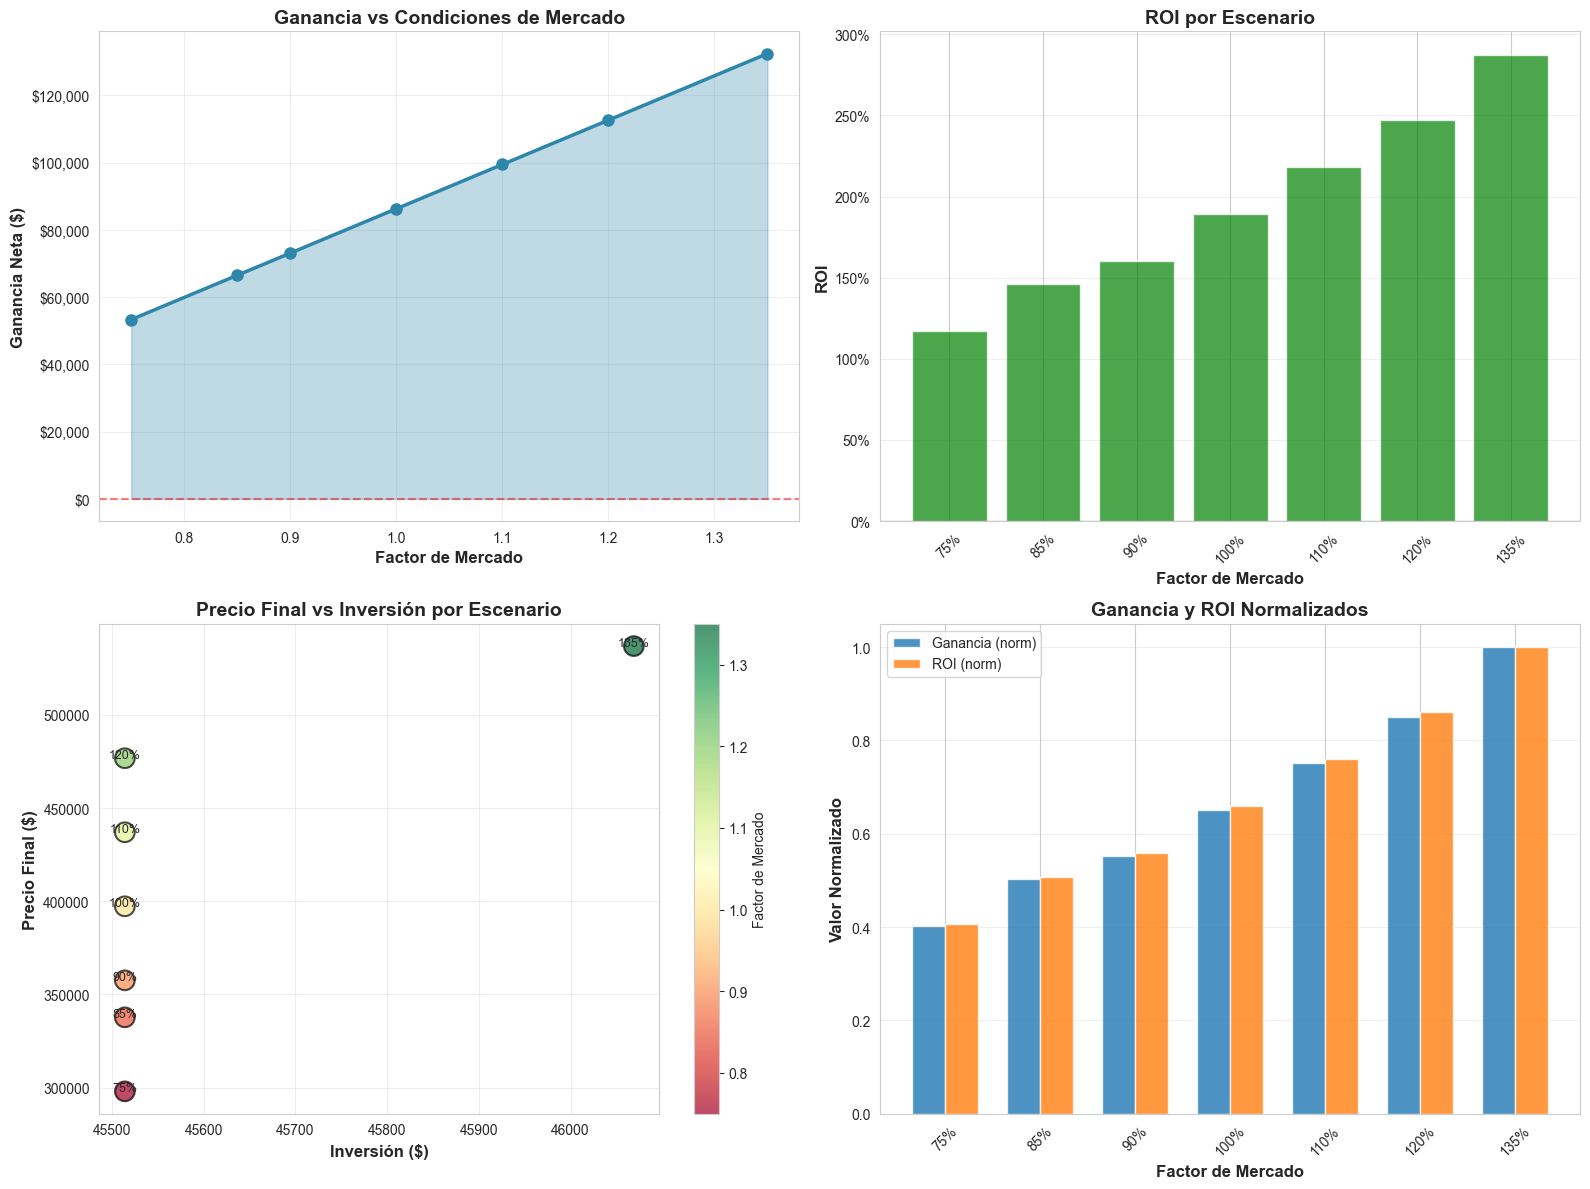

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Ganancia vs Factor de Mercado
ax1 = axes[0, 0]
ax1.plot(df_results['Factor_Mercado'], df_results['Ganancia'], 
         marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.fill_between(df_results['Factor_Mercado'], df_results['Ganancia'], 
                  alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ganancia Neta ($)', fontsize=12, fontweight='bold')
ax1.set_title('Ganancia vs Condiciones de Mercado', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. ROI vs Factor de Mercado
ax2 = axes[0, 1]
colors = ['red' if roi < 0 else 'green' for roi in df_results['ROI']]
ax2.bar(range(len(df_results)), df_results['ROI'], color=colors, alpha=0.7)
ax2.set_xticks(range(len(df_results)))
ax2.set_xticklabels([f"{f:.0%}" for f in df_results['Factor_Mercado']], rotation=45)
ax2.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROI', fontsize=12, fontweight='bold')
ax2.set_title('ROI por Escenario', fontsize=14, fontweight='bold')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='y')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

# 3. Precio Final vs Inversión
ax3 = axes[1, 0]
scatter = ax3.scatter(df_results['Inversión'], df_results['Precio_Final'], 
                     c=df_results['Factor_Mercado'], cmap='RdYlGn', 
                     s=200, alpha=0.7, edgecolors='black', linewidth=1.5)
for i, txt in enumerate(df_results['Escenario']):
    ax3.annotate(f"{df_results['Factor_Mercado'].iloc[i]:.0%}", 
                (df_results['Inversión'].iloc[i], df_results['Precio_Final'].iloc[i]),
                fontsize=9, ha='center')
ax3.set_xlabel('Inversión ($)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precio Final ($)', fontsize=12, fontweight='bold')
ax3.set_title('Precio Final vs Inversión por Escenario', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Factor de Mercado')

# 4. Comparación de métricas clave
ax4 = axes[1, 1]
x_pos = np.arange(len(df_results))
width = 0.35

# Normalizar para visualización
ganancia_norm = df_results['Ganancia'] / df_results['Ganancia'].max()
roi_norm = df_results['ROI'] / df_results['ROI'].max()

ax4.bar(x_pos - width/2, ganancia_norm, width, label='Ganancia (norm)', alpha=0.8)
ax4.bar(x_pos + width/2, roi_norm, width, label='ROI (norm)', alpha=0.8)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"{f:.0%}" for f in df_results['Factor_Mercado']], rotation=45)
ax4.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax4.set_ylabel('Valor Normalizado', fontsize=12, fontweight='bold')
ax4.set_title('Ganancia y ROI Normalizados', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5️⃣ Análisis de Punto de Equilibrio

In [18]:
# Encontrar punto de equilibrio (ganancia = 0)
positive_profits = df_results[df_results['Ganancia'] > 0]
negative_profits = df_results[df_results['Ganancia'] <= 0]

if len(positive_profits) > 0 and len(negative_profits) > 0:
    # Interpolar para encontrar punto exacto
    breakeven_factor = np.interp(0, 
                                 [df_results['Ganancia'].min(), df_results['Ganancia'].max()],
                                 [df_results['Factor_Mercado'].min(), df_results['Factor_Mercado'].max()])
    
    print("="*70)
    print("📊 ANÁLISIS DE PUNTO DE EQUILIBRIO")
    print("="*70)
    print(f"\n🎯 Factor de mercado de equilibrio (aprox): {breakeven_factor:.2%}")
    print(f"   → Por debajo de {breakeven_factor:.2%}: NO conviene invertir")
    print(f"   → Por encima de {breakeven_factor:.2%}: SÍ conviene invertir")
    
    print(f"\n📈 Escenarios RENTABLES ({len(positive_profits)}):")
    for idx, row in positive_profits.iterrows():
        print(f"   • {row['Escenario']:25s} → Ganancia: ${row['Ganancia']:>10,.0f} | ROI: {row['ROI']:>6.1%}")
    
    print(f"\n📉 Escenarios NO RENTABLES ({len(negative_profits)}):")
    for idx, row in negative_profits.iterrows():
        print(f"   • {row['Escenario']:25s} → Ganancia: ${row['Ganancia']:>10,.0f} | ROI: {row['ROI']:>6.1%}")
    
    # Mejor y peor escenario
    best = df_results.loc[df_results['Ganancia'].idxmax()]
    worst = df_results.loc[df_results['Ganancia'].idxmin()]
    
    print(f"\n🏆 MEJOR ESCENARIO: {best['Escenario']}")
    print(f"   Factor: {best['Factor_Mercado']:.0%} | Ganancia: ${best['Ganancia']:,.0f} | ROI: {best['ROI']:.1%}")
    
    print(f"\n⚠️  PEOR ESCENARIO: {worst['Escenario']}")
    print(f"   Factor: {worst['Factor_Mercado']:.0%} | Ganancia: ${worst['Ganancia']:,.0f} | ROI: {worst['ROI']:.1%}")
    
    print(f"\n💡 Diferencia entre mejor y peor: ${best['Ganancia'] - worst['Ganancia']:,.0f}")
    print("="*70)
else:
    print("⚠️  Todos los escenarios son rentables o todos son no rentables")

⚠️  Todos los escenarios son rentables o todos son no rentables


## 6️⃣ Cambios Recomendados por Escenario

Veamos qué variables cambian en cada condición de mercado

In [19]:
# Analizar top 5 cambios por escenario
print("="*80)
print("🔧 TOP 5 INVERSIONES RECOMENDADAS POR ESCENARIO")
print("="*80)

for scenario, result in list(results.items())[::2]:  # Mostrar cada 2 escenarios
    print(f"\n📌 {scenario} (Factor: {result['sensitivity_params']['market_factor']:.0%})")
    print("-"*80)
    
    # Ordenar cambios por costo
    cost_breakdown = result.get('cost_breakdown', {})
    top_5 = sorted(cost_breakdown.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    
    for i, (var, cost) in enumerate(top_5, 1):
        change = result['changes'][var]
        print(f"  {i}. {var:25s} → {change:+8.2f} unidades | Costo: ${cost:>10,.0f}")
    
    print(f"\n  💰 Total invertido: ${result['spent']:,.0f}")
    print(f"  📈 Ganancia esperada: ${result['profit']:,.0f}")
    print(f"  📊 ROI: {result['roi']:.1%}")

🔧 TOP 5 INVERSIONES RECOMENDADAS POR ESCENARIO

📌 Crisis severa (-25%) (Factor: 75%)
--------------------------------------------------------------------------------
  1. Kitchen_Qual              →    +1.00 unidades | Costo: $    20,286
  2. Garage_Finish             →    +2.00 unidades | Costo: $    17,600
  3. Full_Bath                 →    +1.00 unidades | Costo: $    10,386
  4. Garage_Area               →  +110.00 unidades | Costo: $     7,700
  5. Fireplaces                →    +1.00 unidades | Costo: $     6,942

  💰 Total invertido: $45,514
  📈 Ganancia esperada: $53,320
  📊 ROI: 117.2%

📌 Recesión leve (-10%) (Factor: 90%)
--------------------------------------------------------------------------------
  1. Kitchen_Qual              →    +1.00 unidades | Costo: $    20,286
  2. Garage_Finish             →    +2.00 unidades | Costo: $    17,600
  3. Full_Bath                 →    +1.00 unidades | Costo: $    10,386
  4. Garage_Area               →  +110.00 unidades | Costo: $ 

In [20]:
# Parámetros para construcción desde cero
ZERO_PARAMS = {
    'model': model,
    'X': X,
    'y_log': y_log,
    'trained_feats': trained_feats,
    'trained_stats': trained_stats,
    'baseline_idx': None,  # Sin casa base
    'budget': 250000,  # Mayor presupuesto para construcción
    'pwl_k': 25,
    'zero': True  # Construcción desde cero
}

# Ejecutar optimizaciones desde cero
results_zero = {}
for scenario, factor in market_scenarios.items():
    print(f"\n{'='*70}")
    print(f"🏗️  CONSTRUCCIÓN: {scenario}")
    print(f"{'='*70}")
    
    params = ZERO_PARAMS.copy()
    params['market_factor'] = factor
    
    result = optimize_house(**params)
    
    if result and 'profit' in result:
        results_zero[scenario] = result

print(f"\n✅ Completado: {len(results_zero)} escenarios de construcción analizados")


🏗️  CONSTRUCCIÓN: Crisis severa (-25%)

OPTIMIZACIÓN CASA ÓPTIMA

Construyendo casa desde cero en las coordenadas (-93.641806, 42.034662)
Presupuesto disponible: $250,000


/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:196: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"\nConstruyendo casa desde cero en las coordenadas ({float(baseline['Longitude']):.6f}, {float(baseline['Latitude']):.6f})")
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:300: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base = float(baseline.get(f, X[f].median()))
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:300: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  base = float(baseline.get(f, X[f].median())

📌 Factor de mercado aplicado: 75.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0xb96082dd
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  QLMatrix range   [1e+01, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-04, 1e+06]
  QRHS range       [2e+05, 2e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-09, 3e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve added 12010 rows and 0 columns
Presolve removed 0 rows and 3092 columns
Presolve time: 0.19s
Presolved: 1

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

📌 Factor de mercado aplicado: 85.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x6796c92a
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  QLMatrix range   [1e+01, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-04, 1e+06]
  QRHS range       [2e+05, 2e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-09, 3e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve added 12010 rows and 0 columns
Presolve removed 0 rows and 3092 columns
Presolve time: 0.15s
Presolved: 1

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

📌 Factor de mercado aplicado: 90.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x16f09e90
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  QLMatrix range   [1e+01, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-04, 1e+06]
  QRHS range       [2e+05, 2e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-09, 3e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve added 12010 rows and 0 columns
Presolve removed 0 rows and 3092 columns
Presolve time: 0.13s
Presolved: 1

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x22333e3e
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  QLMatrix range   [1e+01, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-04, 1e+06]
  QRHS range       [2e+05, 2e+05]
  PWLCon x range   [1e+01, 1e+01]
  PWLCon y range   [1e+05, 6e+05]
  GenCon rhs range [7e-09, 3e+03]
  GenCon coe range [1e+00, 1e+00]
Presolve added 12010 rows and 0 columns
Presolve removed 0 rows and 3092 columns
Presolve time: 0.14s
Presolved: 14731 rows, 10553 columns, 30779 nonze

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

📌 Factor de mercado aplicado: 110.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads



CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x6ec4d1fd
Model has 2 quadratic constraints
Model fingerprint: 0x6ec4d1fd
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statist

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

📌 Factor de mercado aplicado: 120.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads



CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0xe6c03526
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
Model fingerprint: 0xe6c03526
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

📌 Factor de mercado aplicado: 135.00%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 22.6.0 22H730)

CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.


CPU model: Intel(R) Core(TM) i7-7567U CPU @ 3.50GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads


Consider calling update less frequently.

Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x38fab23f
Model has 2 quadratic constraints
Optimize a model with 2721 rows, 13645 columns and 15467 nonzeros
Model fingerprint: 0x38fab23f
Model has 2 quadratic constraints
Model has 16213 general constraints
Variable types: 907 continuous, 12738 integer (12716 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  QLMatrix range   [1e+01, 6e+04]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 1e+06]
Model has 1621

/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:683: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  deltas = {c: x[c].X - float(baseline[c]) for c in trained_feats}
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:731: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_garage = float(baseline["Garage_Area"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIMA/analisis_sensibilidad/optimizacion_sensible.py:755: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  area_basement = float(baseline["Total_Bsmt_SF"])
/Users/hernanpalacios/Desktop/CAPSTONE_AMESHOUSING/CASA_OPTIM

## 📊 Comparación Construcción desde Cero

In [21]:
# Crear DataFrame comparativo para construcción
df_zero = pd.DataFrame({
    'Escenario': list(results_zero.keys()),
    'Factor_Mercado': [r['sensitivity_params']['market_factor'] for r in results_zero.values()],
    'Precio_Estimado': [r['price_after'] for r in results_zero.values()],
    'Inversión': [r['spent'] for r in results_zero.values()],
    'Ganancia': [r['profit'] for r in results_zero.values()],
    'ROI': [r['roi'] for r in results_zero.values()],
    'N_Variables': [r['num_changes'] for r in results_zero.values()]
})

# Mostrar tabla
display(df_zero.style.format({
    'Factor_Mercado': '{:.0%}',
    'Precio_Estimado': '${:,.0f}',
    'Inversión': '${:,.0f}',
    'Ganancia': '${:,.0f}',
    'ROI': '{:.2%}'
}).background_gradient(subset=['Ganancia'], cmap='RdYlGn'))

,Escenario,Factor_Mercado,Precio_Estimado,Inversión,Ganancia,ROI,N_Variables
0,Crisis severa (-25%),75%,"$205,199","$242,072","$-36,873",-15.23%,9
1,Recesión (-15%),85%,"$239,463","$248,666","$-9,203",-3.70%,11
2,Recesión leve (-10%),90%,"$253,549","$248,666","$4,883",1.96%,11
3,Mercado estable,100%,"$281,721","$248,666","$33,055",13.29%,11
4,Recuperación (+10%),110%,"$309,893","$248,666","$61,227",24.62%,11
5,Boom (+20%),120%,"$338,065","$248,666","$89,399",35.95%,11
6,Burbuja (+35%),135%,"$380,324","$248,666","$131,658",52.95%,11


## 📈 Visualizaciones Construcción

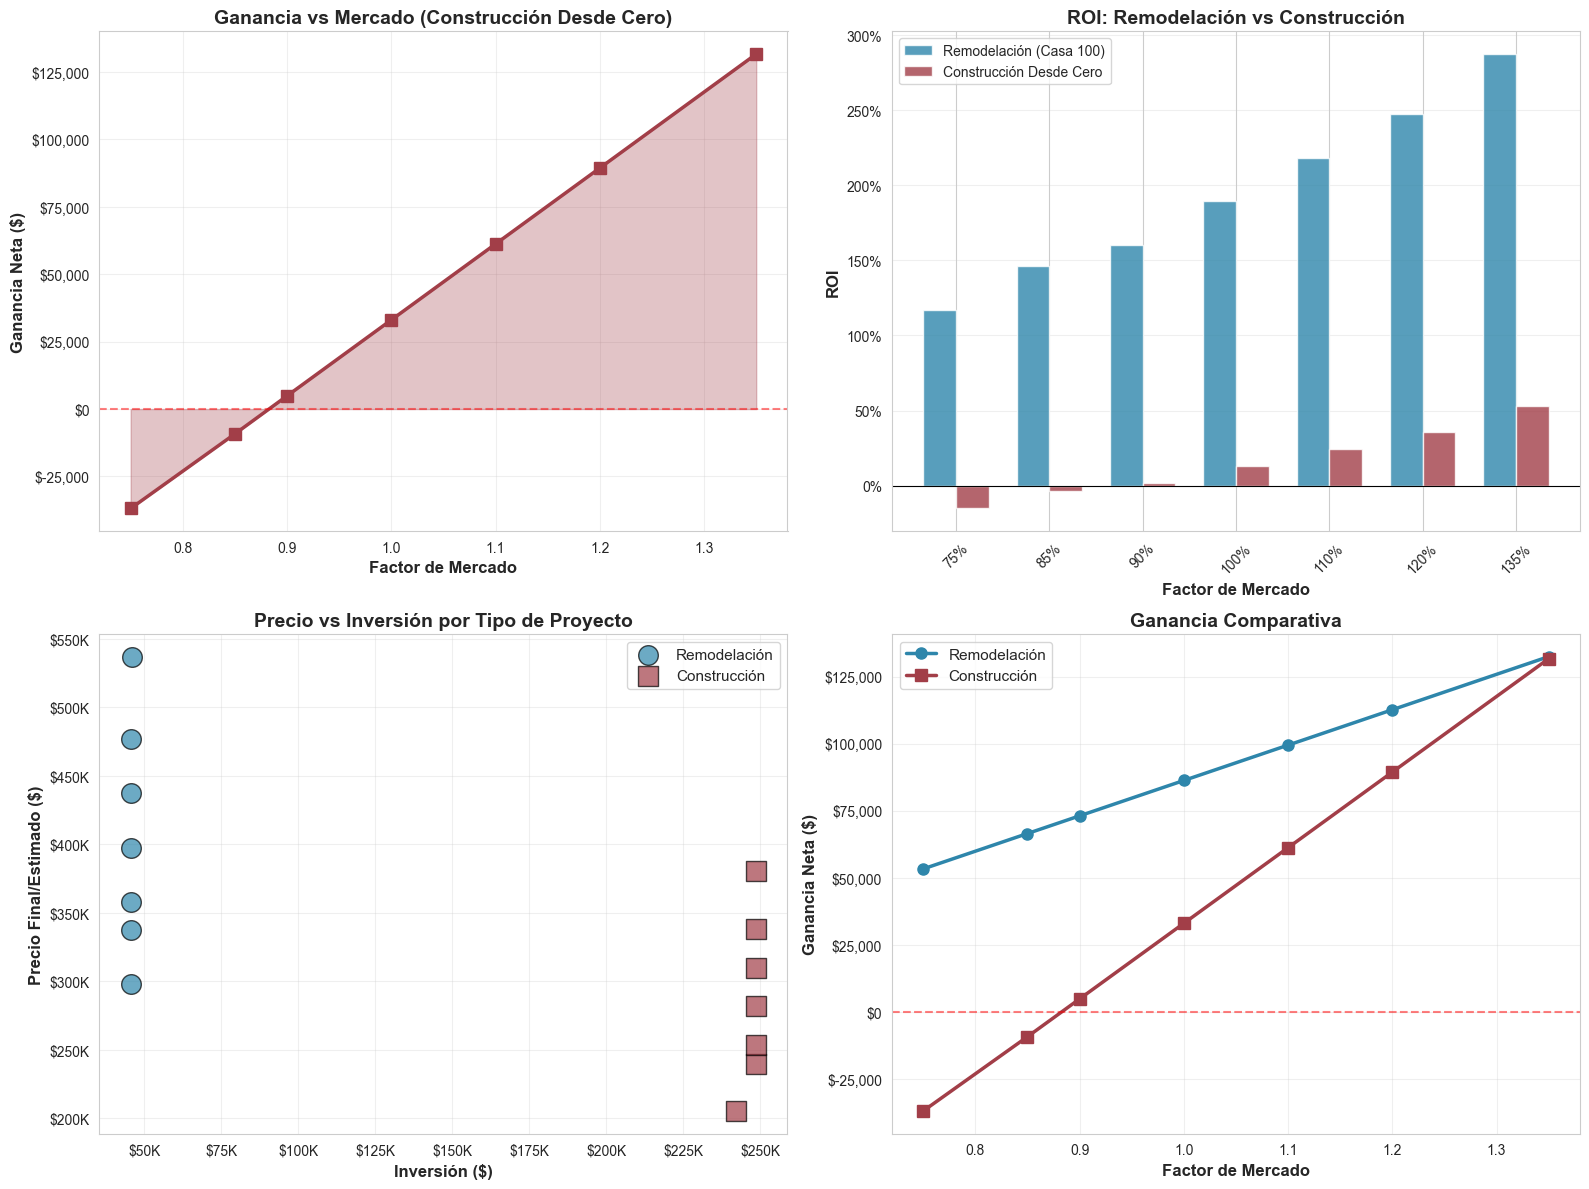

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Ganancia vs Factor de Mercado (Construcción)
ax1 = axes[0, 0]
ax1.plot(df_zero['Factor_Mercado'], df_zero['Ganancia'], 
         marker='s', linewidth=2.5, markersize=8, color='#A23E48')
ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
ax1.fill_between(df_zero['Factor_Mercado'], df_zero['Ganancia'], 
                  alpha=0.3, color='#A23E48')
ax1.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax1.set_ylabel('Ganancia Neta ($)', fontsize=12, fontweight='bold')
ax1.set_title('Ganancia vs Mercado (Construcción Desde Cero)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. ROI Comparativo: Remodelación vs Construcción
ax2 = axes[0, 1]
x = np.arange(len(df_results))
width = 0.35
ax2.bar(x - width/2, df_results['ROI'], width, label='Remodelación (Casa 100)', alpha=0.8, color='#2E86AB')
ax2.bar(x + width/2, df_zero['ROI'], width, label='Construcción Desde Cero', alpha=0.8, color='#A23E48')
ax2.set_xticks(x)
ax2.set_xticklabels([f"{f:.0%}" for f in df_results['Factor_Mercado']], rotation=45)
ax2.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROI', fontsize=12, fontweight='bold')
ax2.set_title('ROI: Remodelación vs Construcción', fontsize=14, fontweight='bold')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

# 3. Precio vs Inversión (ambos casos)
ax3 = axes[1, 0]
ax3.scatter(df_results['Inversión'], df_results['Precio_Final'], 
           s=200, alpha=0.7, label='Remodelación', marker='o', color='#2E86AB', edgecolors='black')
ax3.scatter(df_zero['Inversión'], df_zero['Precio_Estimado'], 
           s=200, alpha=0.7, label='Construcción', marker='s', color='#A23E48', edgecolors='black')
ax3.set_xlabel('Inversión ($)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precio Final/Estimado ($)', fontsize=12, fontweight='bold')
ax3.set_title('Precio vs Inversión por Tipo de Proyecto', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 4. Ganancia Comparativa
ax4 = axes[1, 1]
ax4.plot(df_results['Factor_Mercado'], df_results['Ganancia'], 
         marker='o', linewidth=2.5, markersize=8, label='Remodelación', color='#2E86AB')
ax4.plot(df_zero['Factor_Mercado'], df_zero['Ganancia'], 
         marker='s', linewidth=2.5, markersize=8, label='Construcción', color='#A23E48')
ax4.axhline(0, color='red', linestyle='--', alpha=0.5)
ax4.set_xlabel('Factor de Mercado', fontsize=12, fontweight='bold')
ax4.set_ylabel('Ganancia Neta ($)', fontsize=12, fontweight='bold')
ax4.set_title('Ganancia Comparativa', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

## 💡 Análisis Comparativo Final

In [23]:
print("="*80)
print("📊 ANÁLISIS COMPARATIVO: REMODELACIÓN vs CONSTRUCCIÓN")
print("="*80)

for scenario in market_scenarios.keys():
    if scenario in results and scenario in results_zero:
        rem = results[scenario]
        cons = results_zero[scenario]
        
        print(f"\n{'='*80}")
        print(f"📌 {scenario}")
        print(f"{'='*80}")
        
        print(f"\n🔧 REMODELACIÓN (Casa 100):")
        print(f"   Inversión:    ${rem['spent']:>12,.0f}")
        print(f"   Precio final: ${rem['price_after']:>12,.0f}")
        print(f"   Ganancia:     ${rem['profit']:>12,.0f}")
        print(f"   ROI:          {rem['roi']:>12.2%}")
        
        print(f"\n🏗️  CONSTRUCCIÓN (Desde Cero):")
        print(f"   Inversión:    ${cons['spent']:>12,.0f}")
        print(f"   Precio estim: ${cons['price_after']:>12,.0f}")
        print(f"   Ganancia:     ${cons['profit']:>12,.0f}")
        print(f"   ROI:          {cons['roi']:>12.2%}")
        
        # Comparación
        mejor = "REMODELACIÓN" if rem['roi'] > cons['roi'] else "CONSTRUCCIÓN"
        diff_roi = abs(rem['roi'] - cons['roi'])
        diff_ganancia = abs(rem['profit'] - cons['profit'])
        
        print(f"\n💡 VEREDICTO: {mejor} es mejor opción")
        print(f"   Diferencia ROI:      {diff_roi:>12.2%}")
        print(f"   Diferencia Ganancia: ${diff_ganancia:>12,.0f}")

print(f"\n{'='*80}")

📊 ANÁLISIS COMPARATIVO: REMODELACIÓN vs CONSTRUCCIÓN

📌 Crisis severa (-25%)

🔧 REMODELACIÓN (Casa 100):
   Inversión:    $      45,514
   Precio final: $     297,951
   Ganancia:     $      53,320
   ROI:               117.15%

🏗️  CONSTRUCCIÓN (Desde Cero):
   Inversión:    $     242,072
   Precio estim: $     205,199
   Ganancia:     $     -36,873
   ROI:               -15.23%

💡 VEREDICTO: REMODELACIÓN es mejor opción
   Diferencia ROI:           132.38%
   Diferencia Ganancia: $      90,193

📌 Recesión (-15%)

🔧 REMODELACIÓN (Casa 100):
   Inversión:    $      45,514
   Precio final: $     337,678
   Ganancia:     $      66,498
   ROI:               146.10%

🏗️  CONSTRUCCIÓN (Desde Cero):
   Inversión:    $     248,666
   Precio estim: $     239,463
   Ganancia:     $      -9,203
   ROI:                -3.70%

💡 VEREDICTO: REMODELACIÓN es mejor opción
   Diferencia ROI:           149.81%
   Diferencia Ganancia: $      75,701

📌 Recesión leve (-10%)

🔧 REMODELACIÓN (Casa 100):
   I

## 🏆 Resumen Ejecutivo

In [24]:
print("="*80)
print("🏆 RESUMEN EJECUTIVO - ANÁLISIS DE SENSIBILIDAD")
print("="*80)

# Mejor escenario remodelación
best_rem = df_results.loc[df_results['Ganancia'].idxmax()]
# Mejor escenario construcción
best_cons = df_zero.loc[df_zero['Ganancia'].idxmax()]

print(f"\n📈 MEJOR ESCENARIO REMODELACIÓN:")
print(f"   Escenario:    {best_rem['Escenario']}")
print(f"   Factor:       {best_rem['Factor_Mercado']:.0%}")
print(f"   Inversión:    ${best_rem['Inversión']:,.0f}")
print(f"   Ganancia:     ${best_rem['Ganancia']:,.0f}")
print(f"   ROI:          {best_rem['ROI']:.2%}")

print(f"\n🏗️  MEJOR ESCENARIO CONSTRUCCIÓN:")
print(f"   Escenario:    {best_cons['Escenario']}")
print(f"   Factor:       {best_cons['Factor_Mercado']:.0%}")
print(f"   Inversión:    ${best_cons['Inversión']:,.0f}")
print(f"   Ganancia:     ${best_cons['Ganancia']:,.0f}")
print(f"   ROI:          {best_cons['ROI']:.2%}")

# Promedios
print(f"\n📊 PROMEDIOS POR TIPO DE PROYECTO:")
print(f"\n   Remodelación:")
print(f"      ROI promedio:      {df_results['ROI'].mean():.2%}")
print(f"      Ganancia promedio: ${df_results['Ganancia'].mean():,.0f}")
print(f"      Inversión promedio: ${df_results['Inversión'].mean():,.0f}")

print(f"\n   Construcción:")
print(f"      ROI promedio:      {df_zero['ROI'].mean():.2%}")
print(f"      Ganancia promedio: ${df_zero['Ganancia'].mean():,.0f}")
print(f"      Inversión promedio: ${df_zero['Inversión'].mean():,.0f}")

# Recomendación final
if df_results['ROI'].mean() > df_zero['ROI'].mean():
    print(f"\n💡 RECOMENDACIÓN: En promedio, REMODELACIÓN ofrece mejor ROI")
else:
    print(f"\n💡 RECOMENDACIÓN: En promedio, CONSTRUCCIÓN ofrece mejor ROI")

print(f"\n{'='*80}")

🏆 RESUMEN EJECUTIVO - ANÁLISIS DE SENSIBILIDAD

📈 MEJOR ESCENARIO REMODELACIÓN:
   Escenario:    Burbuja (+35%)
   Factor:       135%
   Inversión:    $46,069
   Ganancia:     $132,418
   ROI:          287.43%

🏗️  MEJOR ESCENARIO CONSTRUCCIÓN:
   Escenario:    Burbuja (+35%)
   Factor:       135%
   Inversión:    $248,666
   Ganancia:     $131,658
   ROI:          52.95%

📊 PROMEDIOS POR TIPO DE PROYECTO:

   Remodelación:
      ROI promedio:      195.25%
      Ganancia promedio: $89,093
      Inversión promedio: $45,593

   Construcción:
      ROI promedio:      15.69%
      Ganancia promedio: $39,164
      Inversión promedio: $247,724

💡 RECOMENDACIÓN: En promedio, REMODELACIÓN ofrece mejor ROI

